# Validating the model

We are now going to validate the model with the set we have reserved at the very beginning of this experiment

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [1]:
from google.colab import drive

# Install required packages
! pip install pandarallel
! pip install opencv-python

# Mount Drive
drive.mount("/content/gdrive", force_remount=True)

file_placement = "/content/gdrive/MyDrive/09 CS659 Image Processing and Analysis/data"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.3 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=fe3f0c42ad59e975cc87fc81205ae237a27d1b145c79b52c35805eb0f1bed201
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive


In [2]:
import torch
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import imageio.v3 as iio
import time

# Loading validation set index

We have saved an excel file as an index to the images we have reserved for validation.

In [3]:
base_folder = os.path.join(file_placement, "..")
validation_set = pd.read_excel(os.path.join(base_folder, "validation_set.xlsx"))
validation_set.head()

,path,set,label,file_name,fruit,fresh,image_info,height,width,channels,pixels_per_channel,total_of_features,total_of_features_rgb
0,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,vertical_flip_Screen Shot 2018-06-08 at 2.36.5...,apples,False,"(368, 372, 3)",368,372,3,136896,410688,410688
1,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,a_r825.png,apples,False,"(408, 350, 3)",408,350,3,142800,428400,428400
2,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,vertical_flip_Screen Shot 2018-06-08 at 5.02.5...,apples,True,"(310, 284, 3)",310,284,3,88040,264120,264120
3,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,Screen Shot 2018-06-08 at 2.40.13 PM.png,apples,False,"(338, 344, 4)",338,344,4,116272,465088,348816
4,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,rotated_by_75_Screen Shot 2018-06-07 at 2.56.4...,apples,False,"(330, 318, 3)",330,318,3,104940,314820,314820


# Pre-processing

We need to apply the same standardization to validation set that we have applied to Train and Test set. For the pre-processing, we define again the same function used before

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_and_pad(image, height = 512, width = 512, padColor = 0):
    h, w, c = image.shape
    size = (height, width)
    sh, sw = size

    # Remove alpha channel if the image has 4 channels
    image_with_4th_channel = None
    if c > 3:
        image_with_4th_channel = image
        image = image[:,:,:3]

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(image.shape) == 3 and not isinstance(padColor, (list, tuple,
        np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3
    padded_image = cv2.copyMakeBorder(image, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)


    # Recalc the aspect ratio
    aspect = w/h
    scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

#     plt.imshow(scaled_img)
    return image_with_4th_channel, padded_image, scaled_img

# Loading saved model

We are going to load the model we have saved in the previous step/notebook in order to use it to predict the "new cases" (images from our validation set)

In [5]:
start_time = time.time()
model_folder = os.path.join(base_folder, "saved_model")
model = torch.load(os.path.join(model_folder, "fresh_apples_classification.pth"), map_location=torch.device('cpu'))
end_time = time.time()
print("Time to load the saved model:", end_time - start_time, "seconds")

Time to load the saved model: 1.9913544654846191 seconds


# Prediction function

Now we create a function that will receive the model and the image. It applies the pre-processing transformation and then loads the image on a tensor, applying the transformations we have applied when loading the train and test dataset.

It also adjusts the dimensions to match of what we have used to train and test (array of 3D images - therefore 4 dimensions).

After the transformations, it used the saved model to predict the image and outputs True if the prediction is for a fresh banana or False otherwise.

In [6]:
def is_fresh(model, image):
    from PIL import Image
    image_with_4th_channel, padded_image, image = resize_and_pad(image)
    image = Image.fromarray(image)
    trans = transforms.Compose([
        transforms.Resize(255),
        transforms.ToTensor()
        ])
    input = trans(image)
    input = input.view(1, 3, 255, 255)
    output = model(input).argmax(axis=1)

    fresh = False
    if output[0].numpy() == 0:
        fresh = True

    return image, fresh

# image = iio.imread(image_path)
# image, predicted_freshness = is_fresh(model, image)
# print("Is fresh?", predicted_freshness)
# plt.imshow(image)
# title = f"True label: Fresh\nPredicted label: Fresh"
# plt.title(title, x=1.1, y=.5, loc="left")
# plt.show()

# Check Validation set performance

We first define a function that gets the path, loads the image and calls the "is_fresh" function created abovem, returning True (fresh) or False (not fresh).

This function will be called by the apply method of the Pandas DataFrame we loaded with the index for the validation set

In [7]:
li = []
def validation_performance_check(path, model):
    start_time = time.time()
    image = iio.imread(path)
    image, predicted_freshness = is_fresh(model, image)
    end_time = time.time()
    row = {
        "start_time": start_time,
        "end_time": end_time,
        "duration": end_time - start_time
    }
    li.append(row)
    return predicted_freshness


validation_set["predicted_freshness"] = validation_set["path"].apply(
    lambda x: validation_performance_check(
        x,
        model
    )
)
prediction_statistics = pd.DataFrame(li)
print("Average time to predict:", prediction_statistics["duration"].mean(), "seconds")

Average time to predict: 0.514546068040679 seconds


In [8]:
validation_set["true_label"] = np.where(validation_set["fresh"], "Fresh", "Not Fresh")
validation_set["predicted_label"] = np.where(validation_set["predicted_freshness"], "Fresh", "Not Fresh")
validation_set.head()

,path,set,label,file_name,fruit,fresh,image_info,height,width,channels,pixels_per_channel,total_of_features,total_of_features_rgb,predicted_freshness,true_label,predicted_label
0,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,vertical_flip_Screen Shot 2018-06-08 at 2.36.5...,apples,False,"(368, 372, 3)",368,372,3,136896,410688,410688,False,Not Fresh,Not Fresh
1,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,a_r825.png,apples,False,"(408, 350, 3)",408,350,3,142800,428400,428400,False,Not Fresh,Not Fresh
2,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,freshapples,vertical_flip_Screen Shot 2018-06-08 at 5.02.5...,apples,True,"(310, 284, 3)",310,284,3,88040,264120,264120,True,Fresh,Fresh
3,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,Screen Shot 2018-06-08 at 2.40.13 PM.png,apples,False,"(338, 344, 4)",338,344,4,116272,465088,348816,False,Not Fresh,Not Fresh
4,/content/gdrive/MyDrive/09 CS659 Image Process...,Train,rottenapples,rotated_by_75_Screen Shot 2018-06-07 at 2.56.4...,apples,False,"(330, 318, 3)",330,318,3,104940,314820,314820,False,Not Fresh,Not Fresh


Now let's print the confusion matrix for the validation set

Text(0.5, 23.52222222222222, '\n\nAccuracy = 1.000\nPrecision = 1.000\nRecall = 1.000\nF1 Score = 1.000')

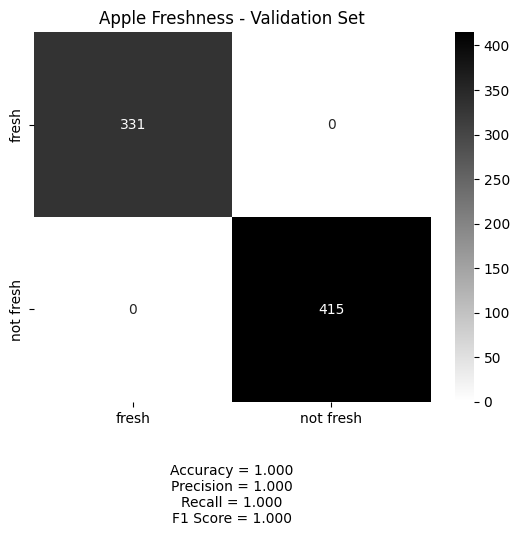

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(validation_set["true_label"], validation_set["predicted_label"])
sns.heatmap(cm, annot=True, fmt=".0f", cmap="binary",
            xticklabels = ["fresh", "not fresh"], yticklabels = ["fresh", "not fresh"])

# Metrics for Binary Confusion Matrices
accuracy  = np.trace(cm) / float(np.sum(cm))
precision = cm[1,1] / sum(cm[:,1])
recall    = cm[1,1] / sum(cm[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\n\nAccuracy = {:0.3f}\nPrecision = {:0.3f}\nRecall = {:0.3f}\nF1 Score = {:0.3f}".format(
    accuracy, precision, recall, f1_score)

plt.title(f"Apple Freshness - Validation Set")
plt.xlabel(stats_text)